In [1]:
import qutip as q
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as cf

Optical linewidth in MHz:  93.62055475993844
Expected T2* linewidth in MHz:  7.957747154594767
Resolution in MHz:  81.40917805212044


C:\Program Files (x86)\Python36\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
C:\Program Files (x86)\Python36\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


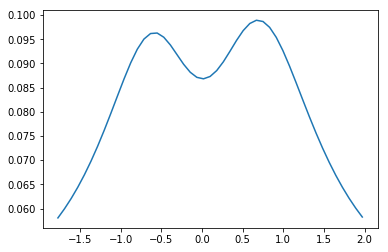

In [51]:
a1 = q.basis(6,0)
a2 = q.basis(6,1)
b1 = q.basis(6,2)
b2 = q.basis(6,3)
c1 = q.basis(6,4)
c2 = q.basis(6,5)

eta = 0.1 # branching ratio
Gamma_pht = 1/(2*np.pi*1.7) 
Gamma_phn = 1/(2*np.pi*10)

Delta = 0.1
Omega1 = Gamma_pht/0.1
Omega2 = eta*Omega1
Hint = Omega1*(a1*c1.dag() + c1*a1.dag()) + Omega2*(a2*c1.dag() + c1*a2.dag())

Gamma_a1 = np.sqrt(Gamma_phn)*(eta*b2+b1)*a1.dag()
Gamma_a2 = np.sqrt(Gamma_phn)*(eta*b1+b2)*a2.dag()
Gamma_b1 = np.sqrt(Gamma_phn)*(eta*a2+a1)*b1.dag()
Gamma_b2 = np.sqrt(Gamma_phn)*(eta*a1+a2)*b2.dag()
Gamma_c1 = np.sqrt(Gamma_pht)*(eta*(b2+a2)+b1+a1)*c1.dag()
Gamma_c2 = np.sqrt(Gamma_pht)*(eta*(b1+a1)+b2+a2)*c2.dag()
Gammas = [Gamma_a1, Gamma_a2, Gamma_b1, Gamma_b2, Gamma_c1, Gamma_c2]

c_ops = []
if Gamma_phn:
    c_ops.append(Gamma_a1)
    c_ops.append(Gamma_a2)
    c_ops.append(Gamma_b1)
    c_ops.append(Gamma_b2)

if Gamma_pht:
    c_ops.append(Gamma_c1)
    c_ops.append(Gamma_c2)

deltas = np.linspace(-20*Gamma_pht, 20*Gamma_pht, 2*Gamma_pht/(Gamma_phn/2*1/2)) + Delta
print("Optical linewidth in MHz: ", Gamma_pht*1e3)
print("Expected T2* linewidth in MHz: ", Gamma_phn/2*1e3)
print("Resolution in MHz: ", np.diff(deltas)[0]*1e3)

c_ss_c1 = []
for delta in deltas:
    Hsys = delta*a2*a2.dag() + Delta*c1*c1.dag()
    rho_ss = q.steadystate(Hsys+Hint, c_ops)
    c_ss_c1.append(rho_ss[-2,-2])

plt.plot(deltas, c_ss_c1)


Text(0.05,0.95,'0.13\n 1.19')

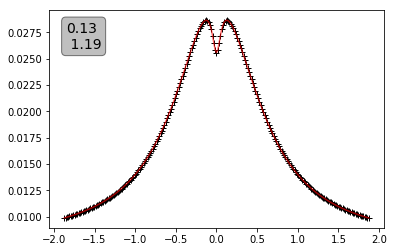

In [44]:
def lorentzian(x, x0, Gamma):
    return (Gamma/2)**2/((x-x0)**2 + (Gamma/2)**2)

def double_lorentzian_fit(x, x01, x02, Gamma1, Gamma2, a1, a2, c):
    return a1*lorentzian(x, x01, Gamma1) + a2*lorentzian(x, x02, Gamma2) +c 

p0 = (Delta, 0, 2*0.5*(1/((Gamma_pht**2/(2*Omega1**2))+1)), 100*Gamma_phn/2, np.abs(np.amax(c_ss_c1)), -np.abs(np.amax(c_ss_c1)), np.abs(np.amin(c_ss_c1)))
popt, pcov = cf(
                double_lorentzian_fit, 
                deltas, np.abs(c_ss_c1),
                p0=p0)

fig, axs = plt.subplots()
axs.plot(deltas, np.abs(c_ss_c1), '+k')
axs.plot(deltas, double_lorentzian_fit(deltas, *popt), '-r', alpha=0.6)
props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

# place a text box in upper left in axes coords
axs.text(0.05, 0.95, f"{round(1/(2*np.pi*popt[2]),2)}\n {round(1/(2*np.pi*popt[3]),2)}", transform=axs.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

In [42]:
2*0.5*(1/((Gamma_pht**2/(2*Omega1**2))+1))

0.8888888888888888

In [29]:
popt

array([-1.83405032e-11, -6.18390332e-09,  1.74289451e+00,  1.53319757e-01,
        2.70988824e-02,  1.30722317e-03,  7.89066326e-03])